In [23]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [24]:
"""
   Description: 
    """

'\n   Description: \n    '

In [25]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
folder_path = Path('./system_analytics_2024/slurm_data')
file_path_parquet_reading = folder_path / 'slurm_data_cleaned.parquet.gzip'
df = pd.read_parquet(file_path_parquet_reading)
df.sample(n=5)




,job_id,Submit,Eligible,Start,End,Elapsed,Slurm_job_id,State,AllocCPUS,TotalCPU,AveRSS,MaxRSS,Number_of_nodes,node_id,node_type,job_run_time,job_waiting_time
0,4044318,2023-10-07 14:38:05,2023-10-07T14:38:05,2023-10-07 14:42:53,2023-10-07 16:26:48,01:43:55,4044318,COMPLETED,48,00:00:00,None,None,1,tcn115,tcn,0 days 01:43:55,0 days 00:04:48
0,5873947,2024-04-12 17:23:45,2024-04-12T17:23:45,2024-04-12 19:02:32,2024-04-13 02:21:29,07:18:57,5873947,COMPLETED,16,00:00:00,None,None,1,tcn392,tcn,0 days 07:18:57,0 days 01:38:47
0,7731304,2024-09-04 15:10:56,2024-09-04T15:11:02,2024-09-04 15:14:58,2024-09-04 15:16:07,00:01:09,7730866_154+,COMPLETED,32,06:31.685,None,None,1,fcn43,fcn,0 days 00:01:09,0 days 00:04:02
7,7811429,2024-09-12 15:31:59,2024-09-12T15:31:59,2024-09-12 15:31:59,2024-09-12 15:40:59,00:09:00,7811429_2.b+,OUT_OF_ME+,16,01:28:02,28860092K,28860092K,1,tcn976,tcn,0 days 00:09:00,0 days 00:00:00
0,7840414,2024-09-13 22:50:25,2024-09-13T22:50:26,2024-09-14 01:06:42,2024-09-14 01:11:41,00:04:59,7834206_5923,COMPLETED,32,02:01:24,None,None,1,fcn47,fcn,0 days 00:04:59,0 days 02:16:17


In [26]:
# removing all the step ids

df = df[(df['Slurm_job_id'].str.contains(pat='^\\d+$', regex=True))]
df.sample(n=5)





,job_id,Submit,Eligible,Start,End,Elapsed,Slurm_job_id,State,AllocCPUS,TotalCPU,AveRSS,MaxRSS,Number_of_nodes,node_id,node_type,job_run_time,job_waiting_time
0,5572444,2024-03-15 22:48:27,2024-03-15T22:48:27,2024-03-15 22:48:27,2024-03-15 22:49:03,00:00:36,5572444,FAILED,384,00:00:00,None,None,2,tcn616,tcn,0 days 00:00:36,0 days 00:00:00
0,8095777,2024-10-06 20:58:22,2024-10-06T20:58:22,2024-10-06 20:58:44,2024-10-06 21:47:02,00:48:18,8095777,COMPLETED,128,02:26:06,None,None,1,tcn563,tcn,0 days 00:48:18,0 days 00:00:22
0,5112935,2024-02-05 12:19:48,2024-02-05T12:19:48,2024-02-05 12:19:48,2024-02-05 13:27:48,01:08:00,5112935,COMPLETED,18,00:00:00,None,None,1,gcn34,gcn,0 days 01:08:00,0 days 00:00:00
0,5321120,2024-02-22 01:00:48,2024-02-22T01:00:48,2024-02-22 01:01:35,2024-02-22 01:19:54,00:18:19,5321120,COMPLETED,32,00:00:00,None,None,1,tcn351,tcn,0 days 00:18:19,0 days 00:00:47
0,5270972,2024-02-19 13:40:01,2024-02-19T13:40:01,2024-02-19 13:53:05,2024-02-19 13:53:38,00:00:33,5270972,COMPLETED,384,00:00:00,None,None,2,tcn651,tcn,0 days 00:00:33,0 days 00:13:04


In [27]:
df[df['job_id'].duplicated()].head()

,job_id,Submit,Eligible,Start,End,Elapsed,Slurm_job_id,State,AllocCPUS,TotalCPU,AveRSS,MaxRSS,Number_of_nodes,node_id,node_type,job_run_time,job_waiting_time


In [13]:
"""
   Add features that you like here and then use them in the next block! 
    """

df['start_hour'] = df['Start'].dt.hour
df['start_day'] = df['Start'].dt.day
df['start_time_date'] = df['Start'].dt.date
df['start_time_day_name'] = df['Start'].dt.day_name()
df['start_time_week'] = df['Start'].dt.isocalendar().week
df['start_month'] = df['Start'].dt.month
df['start_quarter'] = pd.PeriodIndex(df['Start'], freq='Q')
df['start_year_month'] = pd.PeriodIndex(df['Start'], freq='M')
df['start_year'] = df['Start'].dt.year


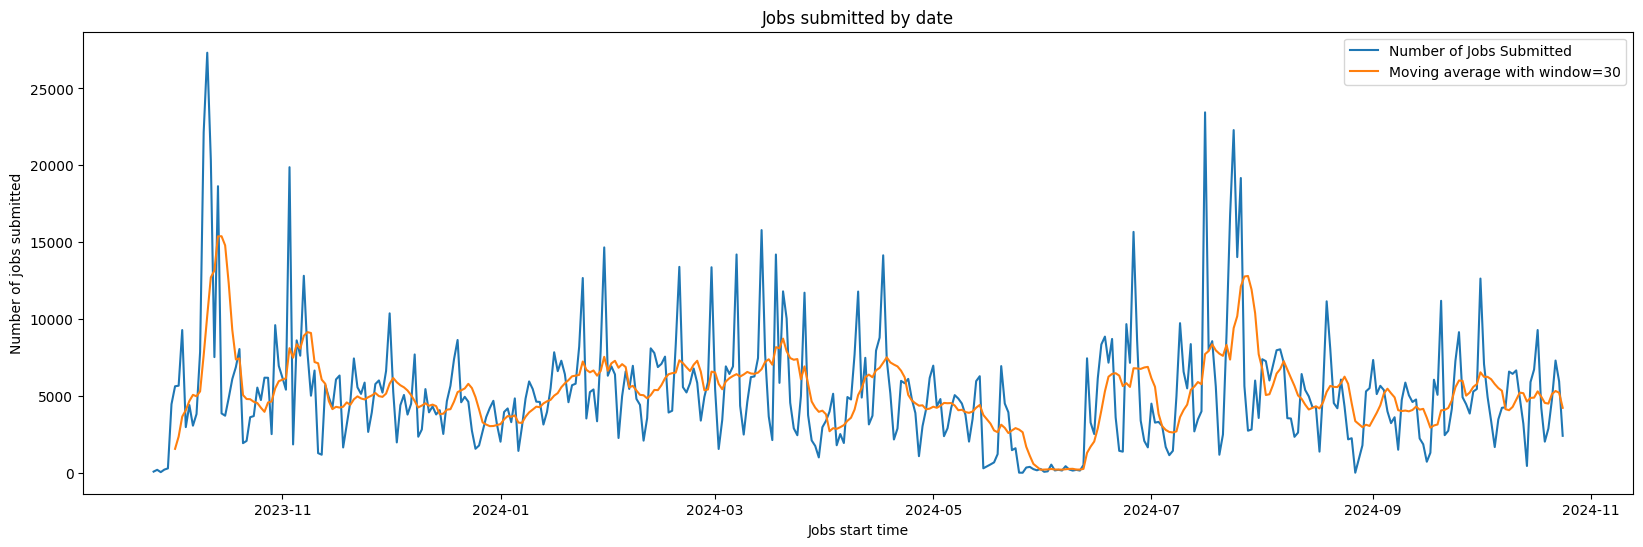

In [14]:
# get the daily numbers of the jobs


df_temp = (df.groupby(['start_time_date'])['job_id'].aggregate(['nunique']))
df_temp['moving_average'] = df_temp['nunique'].rolling(window=7).mean()
df_temp.reset_index(inplace=True)
df_temp.rename(columns={"nunique":"Number_of_jobs_submitted"}, inplace=True)
fig, ax = plt.subplots(figsize=(20, 6))
g1 = sns.lineplot(data=df_temp, x='start_time_date',
             y='Number_of_jobs_submitted', ax=ax, 
             label='Number of Jobs Submitted')
g2 = sns.lineplot(data=df_temp, x='start_time_date',
             y='moving_average', ax=ax, label='Moving average with window=30')

# ax.grid(True)
ax.set_xlabel("Jobs start time")
ax.set_ylabel("Number of jobs submitted")
ax.set_title("Jobs submitted by date")
ax.legend()
plt.show()

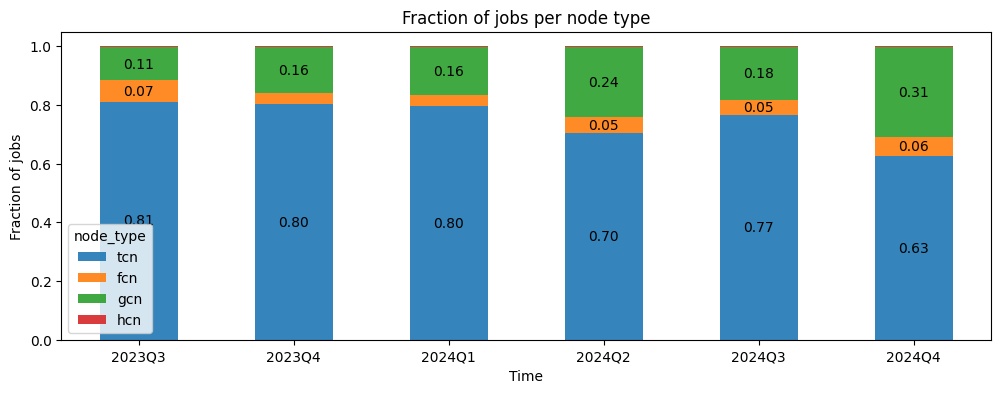

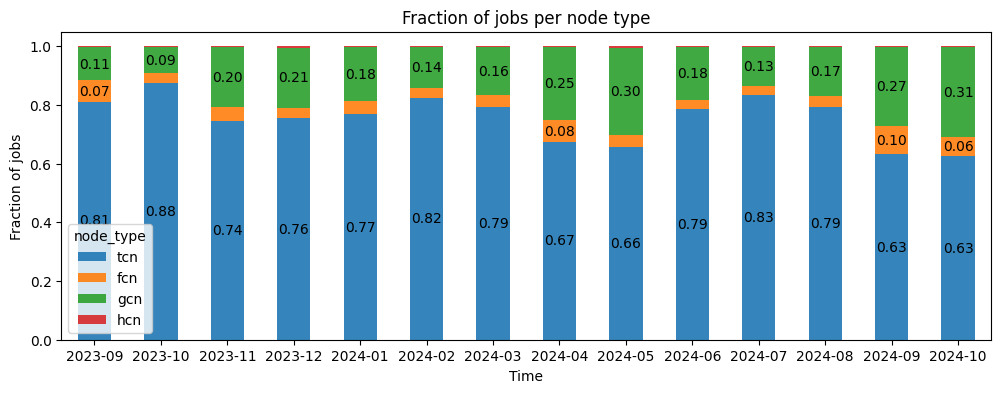

In [15]:
"""
   Observations: 1) Number of submitted jobs for fcn nodes has a sudden increase at 2024Q1!
    """

def stack_plot(col_name):

    total_in_each_season = (df.groupby(col_name[0])[['job_id']].nunique())
    total_in_each_season.rename(columns={"job_id":"Number_of_jobs_submitted"}, inplace=True)
    df_temp = (df.groupby(col_name)[['job_id']].nunique())
    df_temp.reset_index(level=1, inplace=True)
    df_temp['faraction_of_jobs'] = df_temp['job_id'] / total_in_each_season['Number_of_jobs_submitted']
    df_temp.reset_index(inplace=True)
    df_temp.drop('job_id', inplace=True, axis=1)
    df_stacked = df_temp.pivot_table(index=col_name[0], columns='node_type')
    df_stacked = df_stacked.droplevel(level=0, axis=1).copy()
    df_stacked = df_stacked[['tcn', 'fcn', 'gcn', 'hcn']]
    fig, ax = plt.subplots(figsize=(12, 4))
    g= df_stacked.plot(kind='bar', stacked=True,
                    alpha=0.9, ax=ax, use_index=False)
    threshold = 0.05  # Replace with your desired threshold

    for p in g.containers:
        labels = [f'{v.get_height():.2f}' if v.get_height() > threshold else '' for v in p]
        g.bar_label(p, labels=labels, label_type='center')
    ax.set_xlabel("Time")
    ax.set_ylabel("Fraction of jobs")
    ax.set_title("Fraction of jobs per node type")
    ax.set_xticklabels(df_stacked.index.tolist(), rotation=0)


stack_plot(['start_quarter', 'node_type'])
stack_plot(['start_year_month', 'node_type'])

/tmp/ipykernel_2881218/3442863892.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = pd.DataFrame((df.groupby(['cat'])['State'].value_counts(normalize=True)))
/tmp/ipykernel_2881218/3442863892.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_stacked = df_temp.pivot_table(index='cat', columns='State')
/tmp/ipykernel_2881218/3442863892.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = pd.DataFrame((df.groupby(['cat'])[

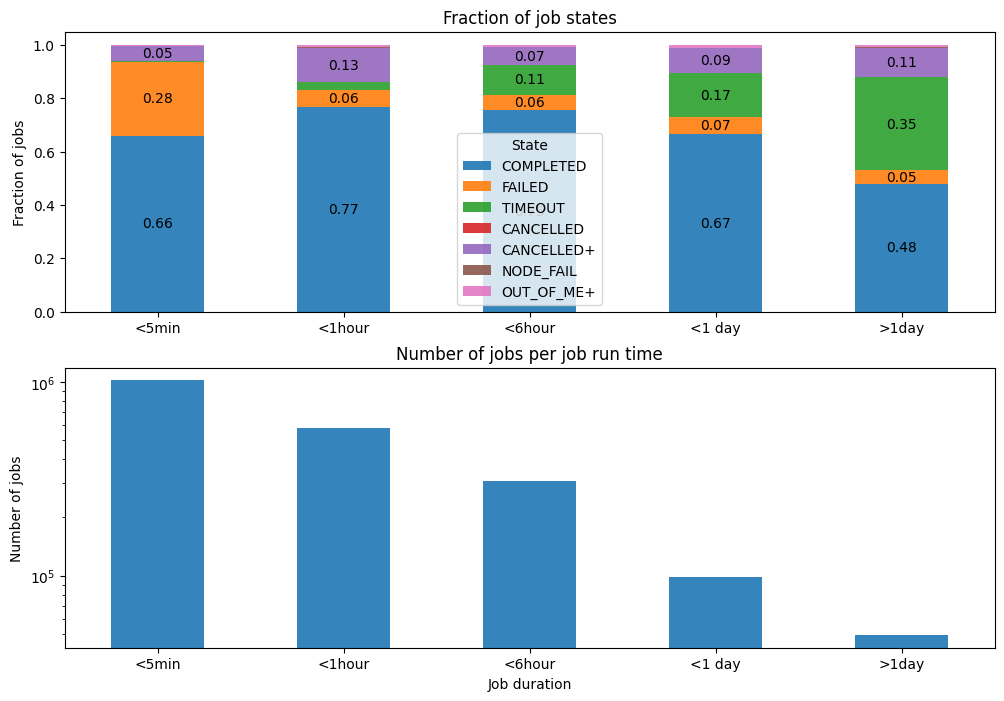

In [16]:
""" 
We analyse the status of a job based on its duration:

Observation1: As the job duration takes a longer time the channce of not being completed increases. 
This has been obsereved before as well.
Observation2: For jobs with duration less than 5 minutes   a noticeable fraction of the jobs fails.
Observation3: If the job run time is between 5 minutes and 6 hours it is likely that complete with sucesses. 
Observation4: A good chunk of the jobs have the duration between 5 minutes and 6 hours.

"""
time_for_cutting = [pd.Timedelta('1s'), pd.Timedelta('5min'),
                    pd.Timedelta('1h'), pd.Timedelta('6h'),
                     pd.Timedelta('1day'), pd.Timedelta('500day')]
labels = pd.cut(df['job_run_time'], bins=time_for_cutting, right=False)
df['cat'] = labels


df_temp = pd.DataFrame((df.groupby(['cat'])['State'].value_counts(normalize=True)))
df_temp.reset_index(inplace=True)

df_stacked = df_temp.pivot_table(index='cat', columns='State')
df_stacked = df_stacked.droplevel(level=0, axis=1).copy()


new_col_order = ['COMPLETED', 'FAILED', 'TIMEOUT', 'CANCELLED', 'CANCELLED+', 
                  'NODE_FAIL', 'OUT_OF_ME+']
df_stacked = df_stacked[new_col_order]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
g = df_stacked.plot(kind='bar', stacked=True,
                alpha=0.9, ax=ax[0], use_index=False)

threshold = 0.05  # Replace with your desired threshold

for p in g.containers:
    labels = [f'{v.get_height():.2f}' if v.get_height() > threshold else '' for v in p]
    g.bar_label(p, labels=labels, label_type='center')
    
# for p in g.containers:
#     g.bar_label(p, fmt='%.2f', label_type='center')

# ax.grid(True)
# ax[0].set_xlabel("Jobs duration")
ax[0].set_ylabel("Fraction of jobs")
ax[0].set_title("Fraction of job states")
ax[0].set_xticklabels(['<5min','<1hour', '<6hour', '<1 day', '>1day'], rotation=0)


df_temp = pd.DataFrame((df.groupby(['cat'])['job_id'].nunique()))
df_temp.reset_index(inplace=True)
df_temp['job_fraction'] = df_temp['job_id']/df_temp['job_id'].sum()
df_temp[['cat','job_id']].plot(kind='bar', alpha=0.9, ax=ax[1], use_index=False, logy=True, legend=False)



# ax.grid(True)
ax[1].set_xlabel("Job duration")
ax[1].set_ylabel("Number of jobs")
ax[1].set_title("Number of jobs per job run time")
ax[1].set_xticklabels(['<5min','<1hour', '<6hour', '<1 day', '>1day'], rotation=0)
plt.show()


In [17]:
# plot for waiting time is missing, a cumulative density function would be great to have






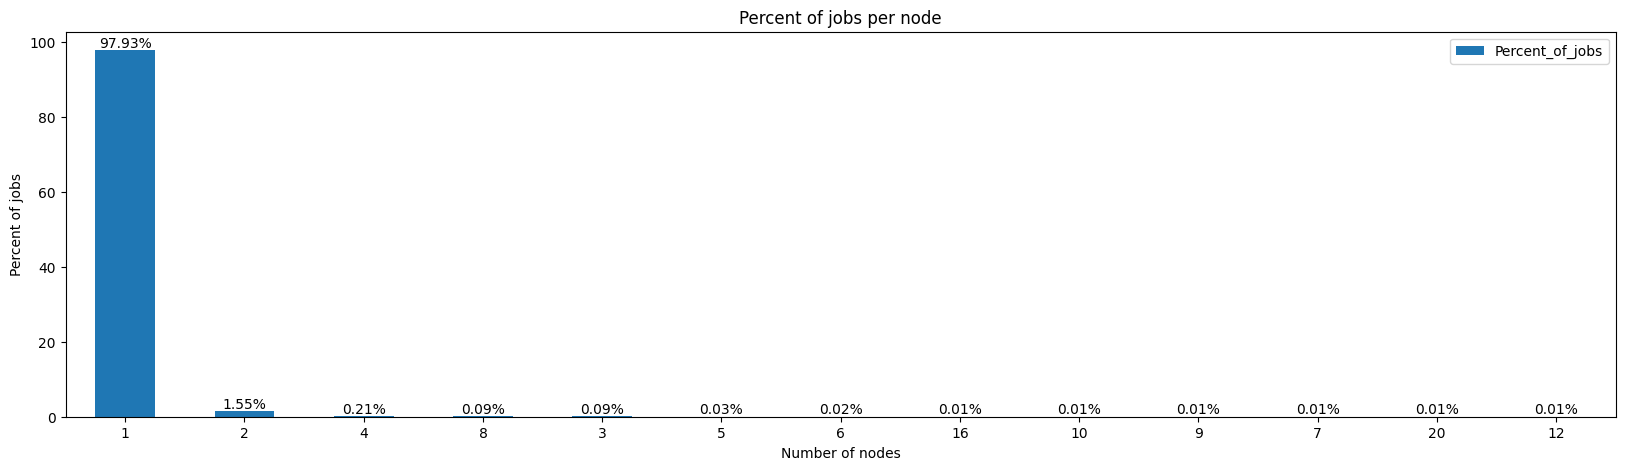

In [18]:
"""
Number of nodes used per job: 
Intersting to see that around 96 percents of the jobs uses 1 node and around 1 percent use 2 nodes. 
"""
df_temp = (df.groupby(['Number_of_nodes'])['job_id'].aggregate(['nunique']))
df_temp.reset_index(inplace=True)
df_temp.rename(columns={"nunique":"Total_number_of_jobs"}, inplace=True)
df_temp['Percent_of_jobs'] = (100 * df_temp['Total_number_of_jobs']) / (df_temp['Total_number_of_jobs'].sum())
df_temp.sort_values(by='Percent_of_jobs', inplace=True, ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
g = df_temp[0:13].plot(kind='bar', x='Number_of_nodes', y='Percent_of_jobs', ax=ax)
for p in g.containers:
    g.bar_label(p, fmt='%.2f%%', label_type='edge')
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Percent of jobs")
ax.set_title("Percent of jobs per node")
ax.set_xticklabels(list(df_temp['Number_of_nodes'])[0:13], rotation=0)
plt.show()

Text(0, 0.5, 'Node type')

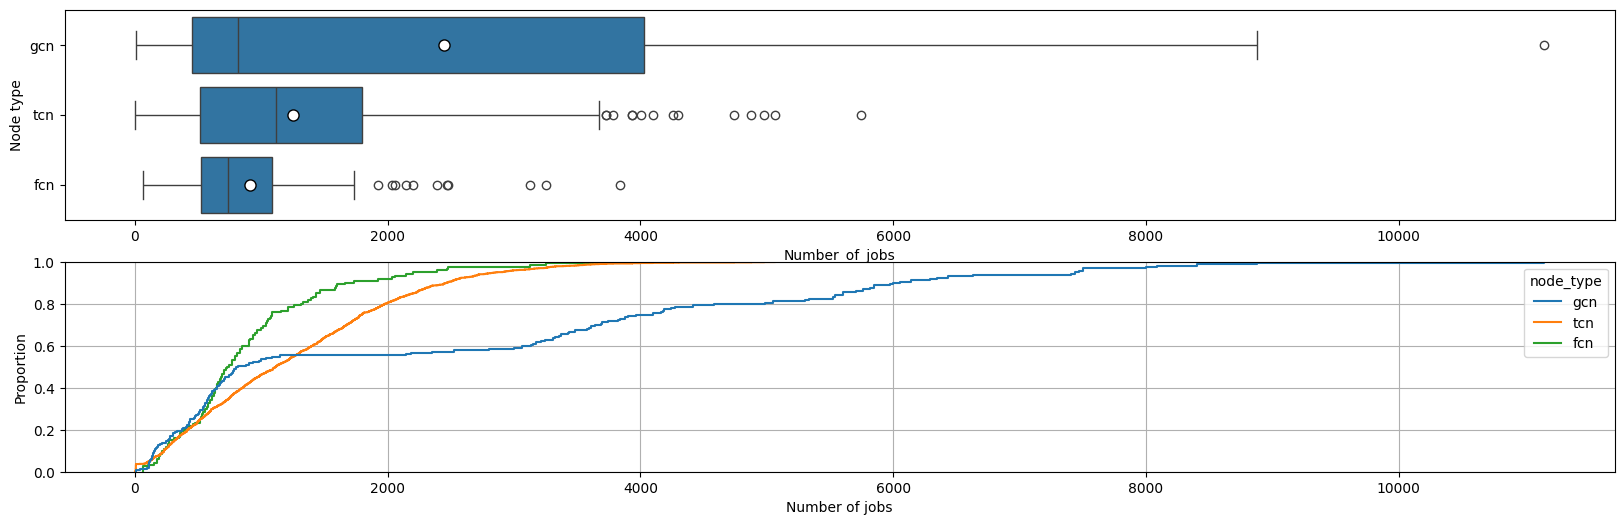

In [19]:
"""
ASSUMPTION: We remove the hcn nodes since there are only 4 of them!
This figure shows the total number of jobs for the nodes (the top one).
Note that we are counting unique job.
Obervation: The data for tcn, gcn and fcn nodes are skewed, e.g, around 50 percent of gcn nodes
do not run as many jobs as their peer groups and 25 percent of them have done more than 
6000 jobs. To put it in another words, around 50 percent of the gcn ndoes have done less than the 
average.
    """

df_temp = (df[~(df['node_type']=='hcn')].groupby(['node_id'])[['job_id']]
                      .nunique().
                      sort_values('job_id', ascending=False))
df_temp.reset_index(inplace=True)
df_temp.rename(columns={"job_id":"Number_of_jobs"}, inplace=True)
df_fin = pd.merge(df_temp, df[['node_id', 'node_type']].drop_duplicates(), on='node_id')
# display(df_fin.head())

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))
sns.boxplot(df_fin, x='Number_of_jobs', y='node_type', showmeans=True, ax=ax[0],
            meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})
# sns.violinplot(df_fin, x='Number_of_jobs', y='node_type', ax=ax)
sns.ecdfplot(df_fin, x='Number_of_jobs', hue='node_type', ax=ax[1])
ax[1].grid()
# sns.histplot(df_fin, x='Number_of_jobs', hue='node_type', ax=ax[1])
# df_fin.plot(kind='hist', x='Number_of_jobs', hue='node_type', ax=ax)
# sns.displot(df_fin, x='Number_of_jobs', hue='node_type', ax=ax, kind='ecdf')
ax[1].set_xlabel("Number of jobs")
ax[0].set_ylabel("Node type")
# ax.set_title("Percent of jobs per node")

